- Angleblock의 자석이 두 겹 (Outer, Inner)으로 배치되어 LAG가 경량화 됨
- Offset과 경계의 개념을 도입하여 LAG와 자석이 직접적인 간섭이 일어나지 않을 수 있도록 함
- 자석을 넣는 직사각형의 각도는 수차 회전 중심점 (B-CRA)를 바라보도록 함.

**V2와 V3의 차이점** : V2는 **연속된 두 자석을 넣는 직사각형의 중심을 이은 선분** 기준으로 자석을 넣는 직사각형의 각도를 정했지만, V3는 그와 달리 **직사각형을 넣는 직사각형이 수차 회전 중심점 (B-CRA)를 바라보도록** 정했다.



## Preview : 자석 경량 Angleblock 제작 DXF, Bruteforce 최적화

### V3 Outer Magnet DXF
**distbtw = 0.5mm, BEST**  <img src="./IMG/outer0.6000000000000002.png" alt="outer0.6.png" width="300"/> **GIF** <img src="./IMG/V3_outer.gif" width="300"/>

### V3 Inner Magnet DXF
**distbtw = 0.6mm, BEST** <img src="./IMG/inner0.3500000000000001.png" alt="inner0.35.png" width="300"/> **GIF** <img src="./IMG/V3_inner.gif" width="300"/>


## V2와 V3의 간단 대조 GIF : 

## Inner : 
V2 : <img src="./IMG/V2_inner.gif" width="300"/> V3 : <img src="./IMG/V3_inner.gif" width="300"/>

In [22]:
import math
import matplotlib.pyplot as plt
import numpy as np
from rectangle import *

# 모든 각도는 라디안 단위로 표현됩니다.
# rectangle : (중심 x, 중심 y, 너비, 높이, 회전)

# 설계 정보
deltay = 0  # mm, LAG delta y
r0 = 60  # 초기 반지름 설정
r_AngleBlock = r0 + deltay  # AngleBlock 반지름 설정

# 주축과 AngleBlock축 (편의상 이심축)의 기울기 관계
theta = 0  # AngleBlock 축에 대한 초기 각도

# 주축 기준 위치 계산
angleblock_theta = []  # 각도 (theta) 저장용 리스트
angleblock_x = []  # x 좌표 저장용 리스트
angleblock_y = []  # y 좌표 저장용 리스트
angleblock_ = []  # (theta, x, y) 튜플 저장용 리스트
angleblock_dot = []  # 점 (x, y) 저장용 리스트

CRA_point = (0, 0)  # CRA 중심점 설정
magnet_dim = (10, 5)  # 자석의 크기 설정 (너비, 높이)
magnet_margin = 0.1  # 자석 여백 설정
maghole_dim = (10.3, 5.3)  # 자석 홀 크기 설정

offset_AB = 3
magnet_boundary_dim = (10, offset_AB * 2 + magnet_dim[1])  # 자석 경계 크기 설정
min_boundary = []  # 최소 경계 (r, theta 형식) 저장용 리스트
max_boundary = []  # 최대 경계 (r, theta 형식) 저장용 리스트

# 이진 탐색 함수 (binary search)
def binary_search(data, target, start, end):
    if start > end:  # 범위를 넘어도 타겟을 찾지 못하면 -1 반환
        return -1

    mid = (start + end) // 2  # 중간값 계산

    if data[mid] == target:  # 중간값이 타겟과 같으면 중간값 인덱스 반환
        return mid 

    elif data[mid] > target:  # 타겟이 작으면 왼쪽을 탐색
        return binary_search(data, target, start, mid - 1)
    else:  # 타겟이 크면 오른쪽을 탐색
        return binary_search(data, target, mid + 1, end)

# CSV 파일에서 각도 블록 데이터를 불러오기
with open('AB_V3.csv', 'r') as file: 
    for line in file:
        dot_ = list(map(float, line.strip().split(',')))
        angleblock_dot.append(dot_)
        angleblock_x.append(dot_[0])
        angleblock_y.append(dot_[1])

        angleblock_theta.append(math.atan2(dot_[1] - CRA_point[1], dot_[0] - CRA_point[0]))


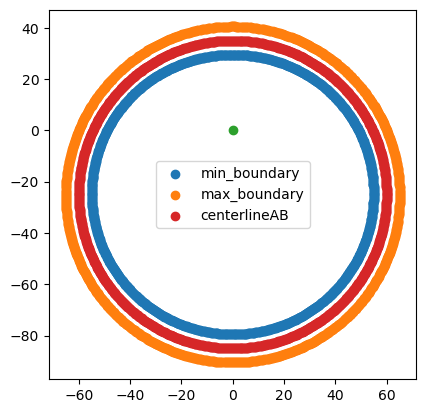

In [23]:

# CRA 기준으로 최소 및 최대 경계 계산
for dot in angleblock_dot: 
    angle_ = math.atan2(dot[1] - CRA_point[1], dot[0] - CRA_point[0])
    min_boundary.append([distance_(dot, CRA_point) - (magnet_boundary_dim[1] / 2), angle_])
    max_boundary.append([distance_(dot, CRA_point) + (magnet_boundary_dim[1] / 2), angle_])

# 경계와 중심선을 시각적으로 표시
plt.scatter(rthetatoxy(min_boundary)[0], rthetatoxy(min_boundary)[1], label='min_boundary')
plt.scatter(rthetatoxy(max_boundary)[0], rthetatoxy(max_boundary)[1], label='max_boundary')
plt.scatter(CRA_point[0], CRA_point[1])
plt.scatter(angleblock_x, angleblock_y, label="centerlineAB")
ax = plt.gca()
ax.legend()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [18]:
dot_cnt = len(angleblock_x)  # 점의 수 계산

In [19]:
# 주어진 위치(pos)와 크기(r_dim)를 바탕으로 사각형을 생성하는 함수
def position_to_rect(pos, r_dim):  # 위치는 r, theta 형식으로 자동 회전
    xcoord = pos[0] * math.cos(pos[1])
    ycoord = pos[0] * math.sin(pos[1])
    return [xcoord, ycoord, r_dim[0], r_dim[1], pos[1] - math.pi / 2]

In [20]:
# 외부 자석 위치를 계산하는 함수
def outer_mag_position(distance_btw): 
    threshold = 0.1  # 거리 임계값 설정
    outer_mag_cnt = 1
    outer_mag_position = []  # r, theta 형식으로 자석의 중심 위치 저장

    outer_mag_position.append([max_boundary[0][0] + magnet_boundary_dim[1] / 2, max_boundary[0][1]])

    for i in range(len(max_boundary)):
        r_ = max_boundary[i][0] + magnet_boundary_dim[1] / 2
        theta_ = max_boundary[i][1]
        nowrect = position_to_rect(outer_mag_position[outer_mag_cnt - 1], maghole_dim)
        nextrect = position_to_rect([r_, theta_], maghole_dim)

        firstrect = position_to_rect(outer_mag_position[0], maghole_dim)

        if min_distance_between_rectangles(nowrect, nextrect) < distance_btw:
            continue 
        elif min_distance_between_rectangles(firstrect, nextrect) > distance_btw * threshold: 
            outer_mag_position.append([r_, theta_])
            outer_mag_cnt += 1
    return outer_mag_position

# 자석 위치를 평가하는 함수 (r, theta 점의 리스트를 입력으로 받음)
def evaluate_mag_position(mag_position): 
    r1 = position_to_rect(mag_position[0], maghole_dim)
    r2 = position_to_rect(mag_position[-1], maghole_dim)
    problem_dist = min_distance_between_rectangles(r1, r2)
    
    totaldist = 0
    size = len(mag_position)
    for i in range(size):
        r1 = position_to_rect(mag_position[i], maghole_dim)
        r2 = position_to_rect(mag_position[(i + 1) % size], maghole_dim)
        totaldist += min_distance_between_rectangles(r1, r2)
    reviseddistancebtw = totaldist / size
    
    return problem_dist

# 자석 위치를 DXF 파일로 저장하는 함수
def mag_pos_dxf(filename, mag_position): 
    from ezdxf import recover
    from ezdxf.addons.drawing import matplotlib
    import ezdxf

    doc = ezdxf.new()

    with open(filename, 'w') as f_: 
        pass
    msp = doc.modelspace()
    
    # 회전된 사각형을 생성하는 내부 함수
    def create_rotated_rectangle(rect):
        centerx, centery, width, height, angle = rect
        # 사각형의 꼭지점을 계산
        half_width = width / 2.0
        half_height = height / 2.0
        
        points = [
            (-half_width, -half_height),
            (half_width, -half_height),
            (half_width, half_height),
            (-half_width, half_height),
            (-half_width, -half_height)  # 루프를 닫기 위해 마지막 점을 다시 추가
        ]

        # 점들을 회전시키고 평행 이동
        rotated_points = []
        for x, y in points:
            xr = x * math.cos(angle) - y * math.sin(angle)
            yr = x * math.sin(angle) + y * math.cos(angle)
            xt = xr + centerx
            yt = yr + centery
            rotated_points.append((xt, yt))

        # 회전된 점들로 사각형을 생성하여 모델 공간에 추가
        msp.add_lwpolyline(rotated_points)

    # DXF 파일을 표시하는 함수
    def display_dxf(filename):
        # 예외 처리는 코드의 간결성을 위해 생략되었습니다.
        doc, auditor = recover.readfile(str(filename))
        if not auditor.has_errors:
            matplotlib.qsave(doc.modelspace(), str(filename[:-4]) + '.png')

    for pos in mag_position:
        create_rotated_rectangle(position_to_rect(pos, maghole_dim))

    doc.saveas(filename)
    display_dxf(filename)

# 내부 자석 위치를 계산하는 함수
def inner_mag_position(distance_btw): 
    threshold = 0.1
    inner_mag_position = []  # r, theta 형식으로 자석의 중심 위치 저장

    # 내부 경계와의 교차 여부를 확인하는 함수
    def rect_intersect_innerbound(rect): 
        for dots in min_boundary: 
            dot_x = dots[0] * math.cos(dots[1])
            dot_y = dots[0] * math.sin(dots[1])
            dotxy = [dot_x, dot_y]

            if point_inside_rect(rect, dotxy):
                return True
        return False

    # 첫 번째 자석 위치 배치
    step = 0.1
    pos = [min_boundary[0][0] - magnet_boundary_dim[1] / 2, 0]
    
    firstrect = position_to_rect(pos, maghole_dim)
    while rect_intersect_innerbound(firstrect):
        pos[0] -= step
        firstrect = position_to_rect(pos, maghole_dim)
    inner_mag_position.append(pos)

    for i in range(len(min_boundary)):
        pos = [min_boundary[i][0] - magnet_boundary_dim[1] / 2, min_boundary[i][1]]
        while rect_intersect_innerbound(position_to_rect(pos, maghole_dim)):
            pos[0] -= step

        # 이전 자석과의 교차 확인
        nowrect = position_to_rect(inner_mag_position[-1], maghole_dim)
        nextrect = position_to_rect(pos, maghole_dim)

        if min_distance_between_rectangles(nowrect, nextrect) < distance_btw:
            continue
        elif min_distance_between_rectangles(firstrect, nextrect) > distance_btw * threshold: 
            inner_mag_position.append(pos)
    return inner_mag_position


In [21]:
# 외부 자석 위치를 계산하고 평가한 후 DXF 파일로 저장
mag_pos = outer_mag_position(1)
print("Evaluation of distbtw:", 1, evaluate_mag_position(mag_pos))
mag_pos_dxf("outer" + str(1) + ".dxf", mag_pos)


Evaluation of distbtw: 1 1.7490823943119131


In [24]:
# 다양한 거리 설정에 대해 자석 위치를 계산하고 평가한 후 DXF 파일로 저장

BTWrange = np.arange(0.1, 1, step=0.05)
for i in BTWrange:
    mag_pos = inner_mag_position(i)
    print("Evaluation of distbtw:", i, evaluate_mag_position(mag_pos))
    mag_pos_dxf("inner" + str(i) + ".dxf", mag_pos)

BTWrange = np.arange(0.1, 1, step=0.05)
for i in BTWrange:
    mag_pos = outer_mag_position(i)
    print("Evaluation of distbtw:", i, evaluate_mag_position(mag_pos))
    mag_pos_dxf("outer" + str(i) + ".dxf", mag_pos)

Evaluation of distbtw: 0.1 17.978837727098597
Evaluation of distbtw: 0.15000000000000002 15.715503805365381
Evaluation of distbtw: 0.20000000000000004 13.155194663410448
Evaluation of distbtw: 0.25000000000000006 12.52239900703428
Evaluation of distbtw: 0.30000000000000004 21.55183704383842
Evaluation of distbtw: 0.3500000000000001 20.901750032772547
Evaluation of distbtw: 0.40000000000000013 20.576711887294632
Evaluation of distbtw: 0.45000000000000007 17.978837727098597
Evaluation of distbtw: 0.5000000000000001 14.750992220421265
Evaluation of distbtw: 0.5500000000000002 14.110641671252608
Evaluation of distbtw: 0.6000000000000002 13.155194663410448
Evaluation of distbtw: 0.6500000000000001 12.52239900703428
Evaluation of distbtw: 0.7000000000000002 10.96014256948492
Evaluation of distbtw: 0.7500000000000002 20.576711887294632
Evaluation of distbtw: 0.8000000000000002 20.576711887294632
Evaluation of distbtw: 0.8500000000000002 18.30315086245245
Evaluation of distbtw: 0.9000000000000